# Prerequisites

In [1]:
%cd drive/My\ Drive/Code19

/content/drive/My Drive/Code19


In [16]:
!tar -xzvf cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
^C


In [3]:
!nvidia-smi

Sun Apr 12 05:53:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install tensorflow==2.0

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,\
    Dropout, Dense, Input, concatenate, ZeroPadding2D,  \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, add, Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall, FalseNegatives, FalsePositives,TrueNegatives,TruePositives, CategoricalCrossentropy
from tensorflow.keras.models import load_model

#from scikitplot.metrics import plot_confusion_matrix, plot_roc

import math  


import os
import numpy as np                                                                                                                                                                                                                                                                                                                                    
import matplotlib.pyplot as plt

# Downloading Data

In [4]:
train_dir = "dataset/train"
validate_dir = "dataset/validate"
test_dir = "dataset/test"

num_of_train = 0
num_of_validate = 0
num_of_test = 0
for label in os.listdir(train_dir):
    for i in os.listdir(os.path.join(train_dir,label)):
        num_of_train+=1

for label in os.listdir(validate_dir):
    for i in os.listdir(os.path.join(validate_dir,label)):
        num_of_validate+=1

for label in os.listdir(test_dir):
    for i in os.listdir(os.path.join(test_dir,label)):
        num_of_test+=1

print(f"Total training sample:{num_of_train}\n",f"Total validating sample:{num_of_validate}\n",f"Total test sample:{num_of_test}")

Total training sample:751
 Total validating sample:172
 Total test sample:65


# Image Resizing and Data Generation

In [0]:
IMG_SIZE = (256,256)
batch_size = 8
epoch = 100

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=IMG_SIZE)

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validate_dir,
                                                              shuffle=True,
                                                              target_size=IMG_SIZE)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=True,
                                                              target_size=IMG_SIZE)

Found 751 images belonging to 3 classes.
Found 172 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


In [7]:
sample_test_images, labels = next(test_data_gen)
print(labels[0:10])
sample_test_images.shape

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


(8, 256, 256, 3)

# Displaying Samples

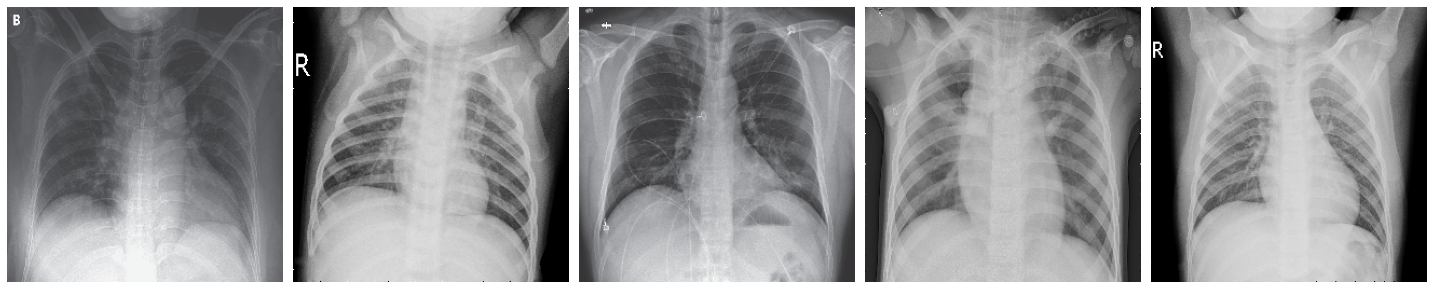

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [8]:
def plotImages(images_arr,labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(labels)
    

plotImages(sample_test_images[:5],labels[:5])



# Model Building

In [10]:
def residual_module(layer_in, n_filters,seq_strides=1,short_cut_stride=1):
    merge_input = layer_in
    x = Conv2D(n_filters, (3,3), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(layer_in)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    # conv2
    x = Conv2D(n_filters, (3,3), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    short_cut = Conv2D(n_filters, (1,1), strides=short_cut_stride, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(merge_input)
    short_cut = BatchNormalization(axis=3)(short_cut)
    short_cut = Activation('linear')(short_cut)
    # add filters, assumes filters/channels last
    layer_out = add([x, short_cut])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

input_layer = Input(shape=(256,256,3))
x = residual_module(input_layer,16,seq_strides=2,short_cut_stride=4)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)

x = residual_module(x,32)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,32)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,32)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)

x = residual_module(x,48)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,48)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,48)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)


x = residual_module(x,64)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,64)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,64)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)


x = residual_module(x,128)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,128)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2())(x)
output = Dense(3,activation='softmax')(x)

largecovidcnn = Model(inputs=input_layer,outputs=output)
largecovidcnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Visualizing Model

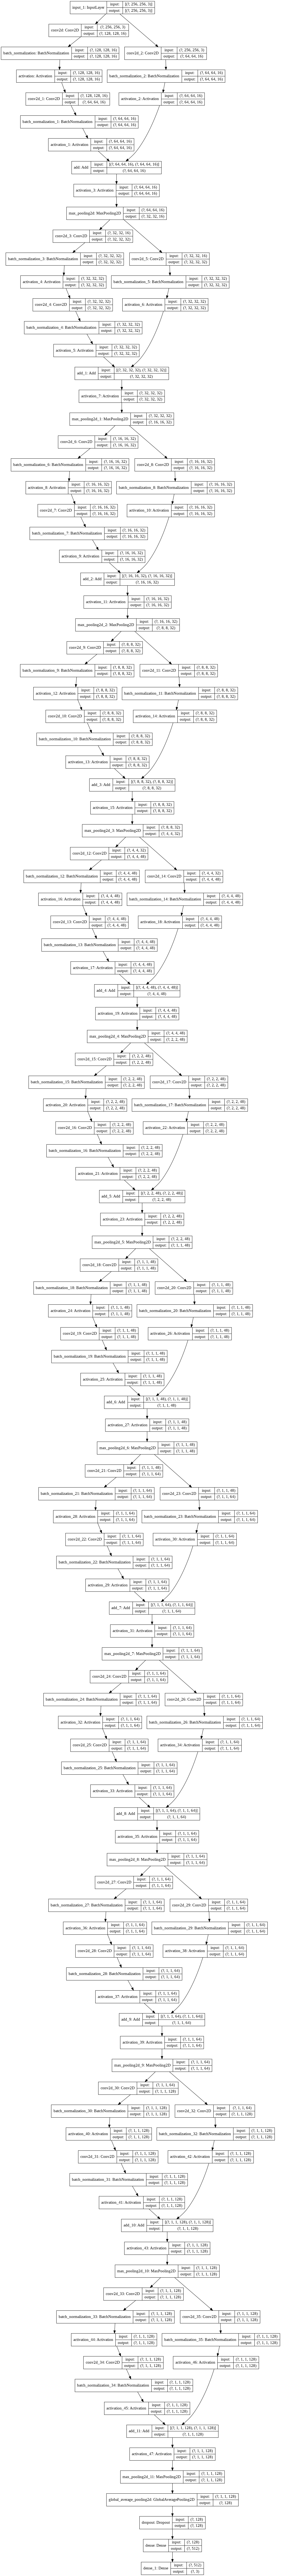

In [41]:
plot_model(largecovidcnn, show_shapes=True, to_file='largecovidcnn.png')

In [11]:
len(largecovidcnn.layers)

149

# Compiling Model

In [0]:
initial_lrate = 0.00008


def decay(epoch, steps=100):
    initial_lrate = 0.00008
    drop = 0.96
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


opt = Adam(lr=initial_lrate)
lr_sc = LearningRateScheduler(decay, verbose=1)


largecovidcnn.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy',AUC(),Precision(),Recall()])

In [13]:
checkpoint = ModelCheckpoint("covid-19_large.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, mode='auto')
callback = [checkpoint,lr_sc]
hist = largecovidcnn.fit_generator(generator=train_data_gen, validation_data= test_data_gen, epochs=epoch,callbacks=callback)


Epoch 00001: LearningRateScheduler reducing learning rate to 8e-05.
Epoch 1/100
93/94 [============================>.] - ETA: 0s - loss: 51.7963 - accuracy: 0.3795 - auc: 0.5416 - precision: 0.3871 - recall: 0.3069
Epoch 00001: val_accuracy improved from -inf to 0.38462, saving model to covid-19_large.h5
94/94 [==============================] - 66s 705ms/step - loss: 51.7683 - accuracy: 0.3835 - auc: 0.5442 - precision: 0.3916 - recall: 0.3103 - val_loss: 49.5287 - val_accuracy: 0.3846 - val_auc: 0.4949 - val_precision: 0.4151 - val_recall: 0.3385

Epoch 00002: LearningRateScheduler reducing learning rate to 8e-05.
Epoch 2/100
93/94 [============================>.] - ETA: 0s - loss: 47.9217 - accuracy: 0.4347 - auc: 0.6149 - precision: 0.4450 - recall: 0.3486
Epoch 00002: val_accuracy did not improve from 0.38462
94/94 [==============================] - 32s 338ms/step - loss: 47.9044 - accuracy: 0.4328 - auc: 0.6145 - precision: 0.4446 - recall: 0.3475 - val_loss: 46.4049 - val_accura

# Plotting Results

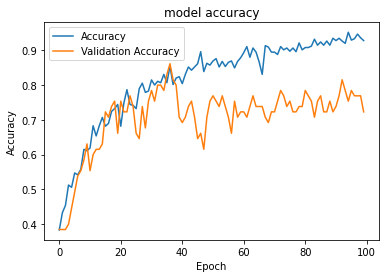

In [14]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

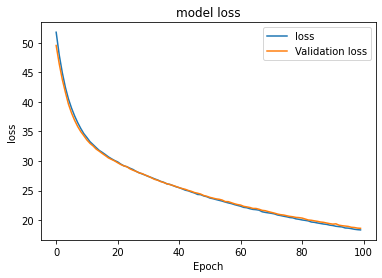

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation loss"])
plt.show()

## Evaluating Model

In [0]:
model = load_model('covid-19_large.h5')

In [34]:
model_metrics = model.evaluate_generator(test_data_gen,verbose=1)

22/22 [==============================] - 7s 305ms/step - loss: 26.1345 - accuracy: 0.8081 - auc: 0.9412 - precision: 0.8514 - recall: 0.7326


In [0]:
f1_score = 2*( (model_metrics[3]*model_metrics[4]) / (model_metrics[3]+model_metrics[4]) )

In [38]:
print(f"Accuracy on test set: {round(model_metrics[1]*100,2)}%")
print(f"ROC(Receiver Operation Characteristic) AUC(Area Under Curve): {model_metrics[2]}")
print(f"Precision: {round(model_metrics[3]*100,2)}%")
print(f"Recall: {round(model_metrics[4]*100,2)}%")
print(f"F1-score: {f1_score}")

Accuracy on test set: 80.81%
ROC(Receiver Operation Characteristic) AUC(Area Under Curve): 0.9412097930908203
Precision: 85.14%
Recall: 73.26%
F1-score: 0.7875000238418579


## Converting tf.keras model to tflite model

In [30]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("covidcnn_large.tflite" , "wb").write(tflite_model)

4071840